In [148]:
import os
import codecs
import random
import nltk
import re
from nltk import word_tokenize
from nltk import NaiveBayesClassifier, classify
from nltk.text import Text
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

载入数据

In [149]:
import os
def load_data(root_path, m_type):
    content_list = []
    for i in range(1,6):
        path = os.path.join(root_path, "enron%d/%s/" % (i, m_type))

        file_list = os.listdir(path)
        for file_name in file_list:
            file_path = os.path.join(path, file_name)
            if os.path.isfile(file_path):
                with open(file_path, encoding='utf-8', errors='ignore') as f:
                    content = ''.join([line.strip() for line in f.readlines()])
                content_list.append(content)
    return content_list

In [150]:
ham = load_data('./data', 'ham')
spam = load_data('./data', 'spam')

数据预处理

In [151]:
#观察数据集
import pandas as pd
spamdf = pd.DataFrame({'email':spam,'label':1})#垃圾邮件标签贴1
hamdf = pd.DataFrame({'email':ham,'label':0})#非垃圾邮件标签贴0
emaildf = pd.concat([spamdf, hamdf], ignore_index=True)#合并

In [152]:
emaildf.head(5)

,email,label
0,Subject: dobmeos with hgh my energy level has ...,1
1,Subject: your prescription is ready . . oxwq s...,1
2,Subject: get that new car 8434people nowthe we...,1
3,"Subject: await your responsedear partner ,we a...",1
4,"Subject: coca cola , mbna america , nascar par...",1


In [153]:
s=emaildf.label.value_counts()

print('垃圾邮件：',s.values[0],'非垃圾邮件：',s.values[1])
print('data size:',s.values[0]+s.values[1])

垃圾邮件： 15045 非垃圾邮件： 12671
data size: 27716


In [154]:
#数据清洗
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def Stemmer(words):
        stem_words = [stemmer.stem(o) for o in words]
        return " ".join(stem_words)    
    

def TextPreProcessing(Text):
    Text = str(Text)
    
    #lowercase string
    Text = Text.lower()
    
    #html tag stripping
    Text = str(Text)
    Text = re.sub('<[^<]+?>', '', Text)
    
    #url normalizing
    Text = re.sub(r'^https?:\/\/.*[\r\n]*', 'httpaddr', Text, flags=re.MULTILINE)
    
    #email normalizing
    Text = re.sub('\S*@\S*\s?', 'emailaddr', Text)
    
    #currency normalizing
    currencies = [['$',"€","£"], ['dollar', "euro", "pound"]]
    for i in range(len(currencies[0])):
        to_find = currencies[0][i]
        to_replace = currencies[1][i]
        Text = Text.replace(to_find, to_replace)
        
    #stemming
    Text = Stemmer(Text.split(" "))
    
        
    #special symbol removal
    Text = re.sub(r'[^a-zA-Z0-9 ]',r'',Text)
    
    #Remove all numbers
    Text = re.sub(r'[0-9]', '', Text)
    
    #remove banned words
    banned = ['hou',"ect","subject",'subj']
    for i in range(len(banned)):
        bannedwordfind = banned[i]
        Text = Text.replace(bannedwordfind, '')
    

    return Text

In [155]:
emaildf['email']=emaildf['email'].apply(TextPreProcessing)

In [156]:
emaildf.head()

,email,label
0,dobmeo with hgh my energi level ha gone up s...,1
1,your prescript is readi oxwq s f elow cost ...,1
2,get that new car peopl nowth weather or clima...,1
3,await your responsedear partner we are a team...,1
4,coca cola mbna america nascar partner with ...,1


In [157]:
#训练集测试集划分
def tt_split(df):
    
    xtrain, xtest, ytrain, ytest = train_test_split(df['email'], df['label'], test_size=0.3,random_state=5)
    
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = tt_split(emaildf)

特征提取

In [158]:
def tfid_vec(train,test):
    
    # initialize vectorizer - we will check ngrams up to length 2
    transformer = TfidfVectorizer(ngram_range=(1,2),min_df=5)
    
    # using the vectorizer to transform the training and test data to numerical values.  
    train_tfid = transformer.fit_transform(train)
    test_tfid = transformer.transform(test)
    
    return train_tfid,test_tfid

xtrain_tfid,xtest_tfid = tfid_vec(xtrain,xtest)

模型训练与评价

In [159]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mymodelNB = MultinomialNB().fit(xtrain_tfid, ytrain)

In [160]:
def plot_matrix(ytest,ypreds,classes,title):
    # Code adapted and tweaked from scikit-learn.org

    cm=confusion_matrix(ytest, ypreds,labels=[1,0])
  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [161]:
def evaluate_model(model,xtest,ytest):
    
    # get class predictions
    ypreds=model.predict(xtest)
    
    # get class probabilities for use in ROC curve
    yprobs=model.predict_proba(xtest)[:,1]
    
    # set model name
    model_name = type(model).__name__
    
    print('\n---------',model_name,'---------\n')
    
    # accuracy score
    score = metrics.accuracy_score(ytest, ypreds, normalize=True, sample_weight=None)
    print('\n\nAcruacy score of ',score)
    
    # call plot_matrix function 
    classes=['spam','ham']
    plt.figure()
    plot_matrix(ytest,ypreds,classes,model_name)
    
    # classification report

    print(metrics.classification_report(ytest, ypreds,target_names=['Spam','Ham']))
    
    # Compute false positive rate, true positive rate, thresholds and area under the ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, yprobs)
    roc_auc = roc_auc_score(ytest, yprobs)
    
    plt.figure()
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.legend(loc="best")
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC '+model_name)
    
    return score,model_name

In [169]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import roc_curve,roc_auc_score


--------- MultinomialNB ---------



Acruacy score of  0.9832832230907997
              precision    recall  f1-score   support

        Spam       0.98      0.99      0.98      4485
         Ham       0.99      0.97      0.98      3830

    accuracy                           0.98      8315
   macro avg       0.98      0.98      0.98      8315
weighted avg       0.98      0.98      0.98      8315



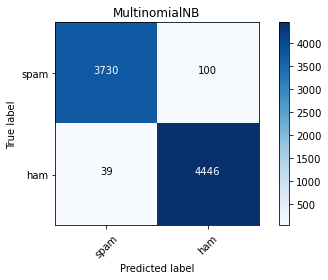

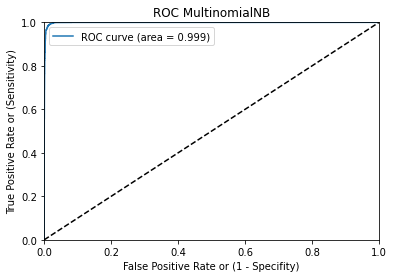

In [170]:
#Multinomial Naive Bayes Performance Metrics

results=[]

score,model_name=evaluate_model(mymodelNB,xtest_tfid,ytest)

results.append((model_name,score))